In [0]:
# Imports
import sys
import math
import numpy as np
import torch

from sklearn.linear_model import LogisticRegression

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torchvision.datasets import MNIST

from itertools import repeat, cycle
from functools import reduce
from operator import __or__

#cuda = torch.cuda.is_available()
import matplotlib.pyplot as plt
%matplotlib inline
#from urllib import request


In [0]:
def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.

    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)


def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.

    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)


def log_standard_categorical(p):
    """
    Calculates the cross entropy between a (one-hot) categorical vector
    and a standard (uniform) categorical distribution.

    :param p: one-hot categorical distribution
    :return: H(p, u)
    """
    # Uniform prior over y
    prior = F.softmax(torch.ones_like(p), dim=1)
    prior.requires_grad = False

    cross_entropy = -torch.sum(p * torch.log(prior + 1e-8), dim=1)

    return cross_entropy

def enumerate_discrete(x, y_dim):
    """
    Generates a `torch.Tensor` of size batch_size x n_labels of
    the given label.
    :param x: tensor with batch size to mimic
    :param y_dim: number of total labels
    :return variable
    """
    def batch(batch_size, label):
        labels = (torch.ones(batch_size, 1) * label).type(torch.LongTensor)
        y = torch.zeros((batch_size, y_dim))
        y.scatter_(1, labels, 1)
        return y.type(torch.LongTensor)

    batch_size = x.size(0)
    generated = torch.cat([batch(batch_size, i) for i in range(y_dim)])

    return Variable(generated.float())


def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode


def log_sum_exp(tensor, dim=-1, sum_op=torch.sum):
    """
    Uses the LogSumExp (LSE) as an approximation for the sum in a log-domain.
    :param tensor: Tensor to compute LSE over
    :param dim: dimension to perform operation over
    :param sum_op: reductive operation to be applied, e.g. torch.sum or torch.mean
    :return: LSE
    """
    max, _ = torch.max(tensor, dim=dim, keepdim=True)
    return torch.log(sum_op(torch.exp(tensor - max), dim=dim, keepdim=True) + 1e-8) + max

def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

In [0]:
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()
        
        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)
        return z

class GaussianSample(Stochastic):
    """
    Layer that represents a sample from a
    Gaussian distribution.
    """
    def __init__(self, in_features, out_features):
        super(GaussianSample, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.mu = nn.Linear(in_features, out_features)
        self.log_var = nn.Linear(in_features, out_features)

    def forward(self, x):
        mu = self.mu(x)
        log_var = F.softplus(self.log_var(x))

        return self.reparametrize(mu, log_var), mu, log_var

class GaussianMerge(GaussianSample):
    """
    Precision weighted merging of two Gaussian
    distributions.
    Merges information from z into the given
    mean and log variance and produces
    a sample from this new distribution.
    """
    def __init__(self, in_features, out_features):
        super(GaussianMerge, self).__init__(in_features, out_features)

    def forward(self, z, mu1, log_var1):
        # Calculate precision of each distribution
        # (inverse variance)
        mu2 = self.mu(z)
        log_var2 = F.softplus(self.log_var(z))
        precision1, precision2 = (1/torch.exp(log_var1), 1/torch.exp(log_var2))

        # Merge distributions into a single new
        # distribution
        mu = ((mu1 * precision1) + (mu2 * precision2)) / (precision1 + precision2)

        var = 1 / (precision1 + precision2)
        log_var = torch.log(var + 1e-8)

        return self.reparametrize(mu, log_var), mu, log_var

class Encoder(nn.Module):
    def __init__(self, dims, sample_layer=GaussianSample):
        """
        Inference network

        Attempts to infer the probability distribution
        p(z|x) from the data by fitting a variational
        distribution q_φ(z|x). Returns the two parameters
        of the distribution (µ, log σ²).

        :param dims: dimensions of the networks
           given by the number of neurons on the form
           [input_dim, [hidden_dims], latent_dim].
        """
        super(Encoder, self).__init__()

        [x_dim, h_dim, z_dim] = dims
        neurons = [x_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.sample = sample_layer(h_dim[-1], z_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        return self.sample(x)


class Decoder(nn.Module):
    def __init__(self, dims):
        """
        Generative network

        Generates samples from the original distribution
        p(x) by transforming a latent representation, e.g.
        by finding p_θ(x|z).

        :param dims: dimensions of the networks
            given by the number of neurons on the form
            [latent_dim, [hidden_dims], input_dim].
        """
        super(Decoder, self).__init__()

        [z_dim, h_dim, x_dim] = dims

        neurons = [z_dim, *h_dim]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)

        self.reconstruction = nn.Linear(h_dim[-1], x_dim)

        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        return self.output_activation(self.reconstruction(x))

class Classifier(nn.Module):
    # need to change this so conforms to other algorithms layer definition
    def __init__(self, dims):
        """
        Single hidden layer classifier
        with softmax output.
        """
        super(Classifier, self).__init__()
        [x_dim, h_dim, y_dim] = dims
        self.dense = nn.Linear(x_dim, h_dim)
        self.logits = nn.Linear(h_dim, y_dim)

    def forward(self, x):
        x = F.relu(self.dense(x))
        x = F.softmax(self.logits(x), dim=-1)
        return x


In [0]:
# models
class VariationalAutoencoder(nn.Module):
    def __init__(self, dims):
        """
        Variational Autoencoder [Kingma 2013] model
        consisting of an encoder/decoder pair for which
        a variational distribution is fitted to the
        encoder. Also known as the M1 model in [Kingma 2014].

        :param dims: x, z and hidden dimensions of the networks
        """
        super(VariationalAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.flow = None

        self.encoder = Encoder([x_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim, list(reversed(h_dim)), x_dim])
        self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, z, q_param, p_param=None):
        """
        Computes the KL-divergence of
        some element z.

        KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
                 = -E[log p(z) - log q(z)]

        :param z: sample from q-distribuion
        :param q_param: (mu, log_var) of the q-distribution
        :param p_param: (mu, log_var) of the p-distribution
        :return: KL(q||p)
        """
        (mu, log_var) = q_param

        if self.flow is not None:
            f_z, log_det_z = self.flow(z)
            qz = log_gaussian(z, mu, log_var) - sum(log_det_z)
            z = f_z
        else:
            qz = log_gaussian(z, mu, log_var)

        if p_param is None:
            pz = log_standard_gaussian(z)
        else:
            (mu, log_var) = p_param
            pz = log_gaussian(z, mu, log_var)

        kl = qz - pz

        return kl

    def add_flow(self, flow):
        self.flow = flow

    def forward(self, x, y=None):
        """
        Runs a data point through the model in order
        to provide its reconstruction and q distribution
        parameters.

        :param x: input data
        :return: reconstructed input
        """
        z, z_mu, z_log_var = self.encoder(x)

        self.kl_divergence = self._kld(z, (z_mu, z_log_var))

        x_mu = self.decoder(z)

        return x_mu

    def sample(self, z):
        """
        Given z ~ N(0, I) generates a sample from
        the learned distribution based on p_θ(x|z).
        :param z: (torch.autograd.Variable) Random normal variable
        :return: (torch.autograd.Variable) generated sample
        """
        return self.decoder(z)


class DeepGenerativeModel(VariationalAutoencoder):
    def __init__(self, dims):
        """
        M2 code replication from the paper
        'Semi-Supervised Learning with Deep Generative Models'
        (Kingma 2014) in PyTorch.

        The "Generative semi-supervised model" is a probabilistic
        model that incorporates label information in both
        inference and generation.

        Initialise a new generative model
        :param dims: dimensions of x, y, z and hidden layers.
        """
        [x_dim, self.y_dim, z_dim, h_dim] = dims
        super(DeepGenerativeModel, self).__init__([x_dim, z_dim, h_dim])

        self.encoder = Encoder([x_dim + self.y_dim, h_dim, z_dim])
        self.decoder = Decoder([z_dim + self.y_dim, list(reversed(h_dim)), x_dim])
        self.classifier = Classifier([x_dim, h_dim[0], self.y_dim])

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x, y):
        # Add label and data and generate latent variable
        z, z_mu, z_log_var = self.encoder(torch.cat([x, y], dim=1))

        self.kl_divergence = self._kld(z, (z_mu, z_log_var))

        # Reconstruct data point from latent data and label
        x_mu = self.decoder(torch.cat([z, y], dim=1))

        return x_mu

    def classify(self, x):
        logits = self.classifier(x)
        return logits

    def sample(self, z, y):
        """
        Samples from the Decoder to generate an x.
        :param z: latent normal variable
        :param y: label (one-hot encoded)
        :return: x
        """
        y = y.float()
        x = self.decoder(torch.cat([z, y], dim=1))
        return x

In [0]:
def get_mnist(location, batch_size, labels_per_class):

    n_labels = 10

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        # reorganize the data by labels and horizontally stack them so the data is like 0..0,1..1,2...2..so on
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])
        indices = torch.from_numpy(indices) # convert into a tensor
        # Samples elements randomly from a given list of indices, without replacement.
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, 
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, 
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, 
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation


In [0]:
class ImportanceWeightedSampler(object):
    """
    Importance weighted sampler [Burda 2015] to
    be used in conjunction with SVI.
    """
    def __init__(self, mc=1, iw=1):
        """
        Initialise a new sampler.
        :param mc: number of Monte Carlo samples
        :param iw: number of Importance Weighted samples
        """
        self.mc = mc
        self.iw = iw

    def resample(self, x):
        return x.repeat(self.mc * self.iw, 1)

    def __call__(self, elbo):
        elbo = elbo.view(self.mc, self.iw, -1)
        elbo = torch.mean(log_sum_exp(elbo, dim=1, sum_op=torch.mean), dim=0)
        return elbo.view(-1)

class SVI(nn.Module):
    """
    Stochastic variational inference (SVI).
    """
    base_sampler = ImportanceWeightedSampler(mc=1, iw=1)
    def __init__(self, model, likelihood=F.binary_cross_entropy, beta=repeat(1), sampler=base_sampler):
        """
        Initialises a new SVI optimizer for semi-supervised learning.
        :param model: semi-supervised model to evaluate
        :param likelihood: p(x|y,z) for example BCE or MSE
        :param sampler: sampler for x and y, e.g. for Monte Carlo
        :param beta: warm-up/scaling of KL-term
        """
        super(SVI, self).__init__()
        self.model = model
        self.likelihood = likelihood
        self.sampler = sampler
        self.beta = beta

    def forward(self, x, y=None):
        is_labelled = False if y is None else True

        # Prepare for sampling
        xs, ys = (x, y)

        # Enumerate choices of label
        if not is_labelled:
            ys = enumerate_discrete(xs, self.model.y_dim)
            xs = xs.repeat(self.model.y_dim, 1)

        # Increase sampling dimension
        xs = self.sampler.resample(xs)
        ys = self.sampler.resample(ys)

        reconstruction = self.model(xs, ys)

        # p(x|y,z)
        likelihood = -self.likelihood(reconstruction, xs)

        # p(y)
        prior = -log_standard_categorical(ys)

        # Equivalent to -L(x, y)
        elbo = likelihood + prior - next(self.beta) * self.model.kl_divergence
        L = self.sampler(elbo)

        if is_labelled:
            return torch.mean(L)

        logits = self.model.classify(x)

        L = L.view_as(logits.t()).t()

        # Calculate entropy H(q(y|x)) and sum over all labels
        H = -torch.sum(torch.mul(logits, torch.log(logits + 1e-8)), dim=-1)
        L = torch.sum(torch.mul(logits, L), dim=-1)

        # Equivalent to -U(x)
        U = L + H
        return torch.mean(U)

## Evaluate M2


In [43]:
y_dim = 10
z_dim = 32
h_dim = [256, 128]
model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])
model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


DeepGenerativeModel(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=794, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=128, out_features=32, bias=True)
      (log_var): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden): ModuleList(
      (0): Linear(in_features=42, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
    )
    (reconstruction): Linear(in_features=256, out_features=784, bias=True)
    (output_activation): Sigmoid()
  )
  (classifier): Classifier(
    (dense): Linear(in_features=784, out_features=256, bias=True)
    (logits): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [0]:
# Only use N labelled examples per class
# The rest of the data is unlabelled.
sampler = ImportanceWeightedSampler(mc=1, iw=1)
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)

# number of labelled instances per class
N_labels = [10, 50, 100, 200, 500, 1000, 2500]
BATCH_SIZE = 32
accuracys = []

for N in N_labels:
    model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])   

    labelled, unlabelled, validation = get_mnist(location="./", batch_size=BATCH_SIZE, labels_per_class=N)
    alpha = 0.1 * len(unlabelled) / len(labelled)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
    print("Label per class = ", N)

    for epoch in range(5):
        # tell the model to train
        model.train()
        total_loss, accuracy = (0, 0)

        labelled_iter = iter(labelled)
      
       # making sure we've seen all labelled cases:
       # if no labelled case iter until we see one
        for (u, _) in unlabelled:
            labelled_elem = next(labelled_iter, None)
            if labelled_elem is None:
                labelled_iter = iter(labelled)
                labelled_elem = next(labelled_iter, None)
            (x, y) = labelled_elem

        # for (x, y), (u, _) in zip(iter(labelled), iter(unlabelled)):
        #     # maybe bounded by the shortest, need to maintain a separate iterator for the labelled data
        #     # forward + backward + optimize
        #     # Wrap in variables
            x, y, u = Variable(x), Variable(y), Variable(u)
            
            L = -elbo(x, y)
            U = -elbo(u) # using unlabelled data
            # Add auxiliary classification loss q(y|x)
            logits = model.classify(x)
            
            # Regular cross entropy
            classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L - alpha * classication_loss + U

            J_alpha.backward()
            # update params
            optimizer.step()

            # clear params 
            optimizer.zero_grad()

            total_loss += torch.Tensor.item(J_alpha.data)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
        # end of each epoch 
        if epoch % 1 == 0:
            # tell the model to test
            model.eval()
            m = len(unlabelled)
            print("training")
            print("Epoch: {}".format(epoch+1))
            print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

            total_loss, accuracy = (0, 0)

            for x, y in validation:
                x, y = Variable(x), Variable(y)
                L = -elbo(x, y)
                U = -elbo(x)

                logits = model.classify(x)
                classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()
                J_alpha = L + alpha * classication_loss + U
                total_loss += torch.Tensor.item(J_alpha.data)
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

            m = len(validation)
            print("validation")
            print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m ))
            accuracys.append(accuracy / m)

            return accuracys

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Label per class =  10


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


training
Epoch: 1
[Train]		 J_a: 1120.83, accuracy: 0.99
validation
[Validation]	 J_a: 1160.94, accuracy: 0.74
training
Epoch: 2
[Train]		 J_a: 1116.73, accuracy: 1.00
validation
[Validation]	 J_a: 1167.25, accuracy: 0.73
training
Epoch: 3
[Train]		 J_a: 1116.73, accuracy: 1.00
validation
[Validation]	 J_a: 1172.30, accuracy: 0.74
training
Epoch: 4
[Train]		 J_a: 1116.63, accuracy: 1.00
validation
[Validation]	 J_a: 1175.51, accuracy: 0.74
training
Epoch: 5
[Train]		 J_a: 1116.71, accuracy: 1.00
validation
[Validation]	 J_a: 1179.76, accuracy: 0.74
Label per class =  50
training
Epoch: 1
[Train]		 J_a: 1118.02, accuracy: 0.97
validation
[Validation]	 J_a: 1122.36, accuracy: 0.86
training
Epoch: 2
[Train]		 J_a: 1116.40, accuracy: 1.00
validation
[Validation]	 J_a: 1123.05, accuracy: 0.86
training
Epoch: 3
[Train]		 J_a: 1116.39, accuracy: 1.00
validation
[Validation]	 J_a: 1123.81, accuracy: 0.86
training
Epoch: 4
[Train]		 J_a: 1116.33, accuracy: 1.00
validation
[Validation]	 J_a: 112

In [0]:
test_error

[tensor(0.7366),
 tensor(0.7322),
 tensor(0.7360),
 tensor(0.7370),
 tensor(0.7359),
 tensor(0.8572),
 tensor(0.8626),
 tensor(0.8639),
 tensor(0.8654),
 tensor(0.8656),
 tensor(0.8888),
 tensor(0.8974),
 tensor(0.8991),
 tensor(0.9058),
 tensor(0.9051),
 tensor(0.9088),
 tensor(0.9184),
 tensor(0.9194),
 tensor(0.9263),
 tensor(0.9246),
 tensor(0.9243),
 tensor(0.9347),
 tensor(0.9420),
 tensor(0.9438),
 tensor(0.9463),
 tensor(0.9290),
 tensor(0.9449),
 tensor(0.9526),
 tensor(0.9523),
 tensor(0.9558),
 tensor(0.9347),
 tensor(0.9501),
 tensor(0.9602),
 tensor(0.9641),
 tensor(0.9674)]

In [0]:
accuracys = np.array([float(i.numpy()) for i in test_error])

In [0]:
error = 1-accuracys[np.arange(4,35,5)]

In [0]:
error

array([0.26407748, 0.13438499, 0.09494805, 0.07537937, 0.05371404,
       0.04422921, 0.03264779])

In [0]:
# just copying the results, don't want to run again. should have stored the results
error = [0.26407748, 0.13438499, 0.09494805, 0.07537937, 0.05371404,
       0.04422921, 0.03264779]

Text(0, 0.5, 'testing error')

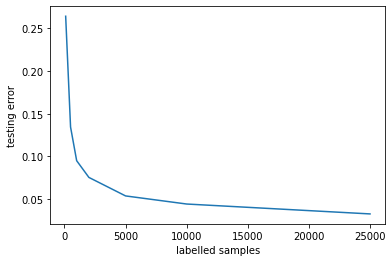

In [203]:
N_labels = [10, 50, 100, 200, 500, 1000, 2500] # sampled from each class
N_labels_scaled = [i*10 for i in N_labels] # times 10 for each class for total
plt.plot(N_labels_scaled, error)
plt.xlabel("labelled samples")
plt.ylabel("testing error")

## Evaluate M1

In [0]:
def get_mnist_VAE(location, batch_size, labels_per_class):

    n_labels = 10

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_indices(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        # reorganize the data by labels and horizontally stack them so the data is like 0..0,1..1,2...2..so on
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])
        indices = torch.from_numpy(indices) # convert into a tensor
        return indices
    
    # Datasets for MNIST, convert those into numpy arrayes for the SVM 
    indices =  get_indices(mnist_train.train_labels.numpy(), labels_per_class)
    x_train = mnist_train.data.numpy()
    y_train = mnist_train.targets.numpy()
    labelled_train_x = x_train[indices]
    #labelled_x = [i.flatten() for i in labelled_x]
    labelled_train_y = y_train[indices]
    # l,w,h = x_train.shape
    # mask = np.zeros(l,dtype=bool) 
    # mask[indices] = True
    # unlabelled_train_x = x_train[~mask]
    # #unlabelled_x = [i.flatten() for i in unlabelled_x]
    # unlabelled_train_y = y_train[~mask]
    train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2) 
    x_valid = mnist_valid.data.numpy()
    y_valid = mnist_valid.targets.numpy()

    return train, labelled_train_x, labelled_train_y, x_valid, y_valid


In [192]:
# Train M1 model Variational encoder

# number of labelled instances per class, there are 10000 instances in total in train so N label is smaller
N_labels = [10, 50, 100, 200, 300, 400, 500]
M1_accuracys = []

for n_label in N_labels: 
    print("labels per class: ", n_label)
    model = VariationalAutoencoder([784, 32, [256, 128]]) # generative
    clf = LogisticRegression(multi_class='multinomial') # discrimative
    train, labelled_train_x, labelled_train_y, x_valid, y_valid = get_mnist_VAE(location="./", batch_size=32, labels_per_class=n_label)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

    for epoch in range(5):
        # tell the model to train
        model.train()
        total_loss = 0
        # VAE training doesn't require y and we go through all training examples

        for (x, y) in iter(train): 
            
            # Generative Training 
            x = Variable(x)

            reconstruction = model(x)
            
            likelihood = -binary_cross_entropy(reconstruction, x)
            elbo = likelihood - model.kl_divergence
            
            L = -torch.mean(elbo)

            L.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += torch.Tensor.item(L.data)        
        m = len(train)
        # at the end of the epoch
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")   

    # Discriminative Training (train once with all labelled data and z generated by fully trained generator in this epoch)
    n, l, w =  labelled_train_x.shape
    labelled_train_x.shape = (n, l*w)
    labelled_train_x_tensor = torch.from_numpy(labelled_train_x)
    # use the trained model to obtain the latent representation of x
    x_latent = model(Variable(labelled_train_x_tensor.float())) 
    class_labels = labelled_train_y
    clf.fit(x_latent.detach().numpy(), class_labels)
    
    ##### validate when all epoches are done
    # reshape the labelled x 
    n, l, w = x_valid.shape
    x_valid.shape = (n, l*w)
    x_valid_tensor = torch.from_numpy(x_valid)

    # use the trained model to obtain the latent representation of x
    x_latent = model(Variable(x_valid_tensor.float()))

    # use trained clf to predict y 
    y_pred = clf.predict(x_latent.detach().numpy())

    # calculate accuracy
    accuracy = sum(y_pred == y_valid)/len(y_valid)
    print("accuray: ", accuracy)
    M1_accuracys.append(accuracy)

labels per class:  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 181.63
Epoch: 1	L: 151.31
Epoch: 2	L: 144.80
Epoch: 3	L: 141.12
Epoch: 4	L: 138.86


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuray:  0.8033
labels per class:  50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 181.70
Epoch: 1	L: 151.02
Epoch: 2	L: 144.45
Epoch: 3	L: 141.10
Epoch: 4	L: 138.95
accuray:  0.8908
labels per class:  100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 181.79
Epoch: 1	L: 151.09
Epoch: 2	L: 144.64
Epoch: 3	L: 141.13
Epoch: 4	L: 138.71
accuray:  0.902
labels per class:  200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 182.86
Epoch: 1	L: 152.14
Epoch: 2	L: 145.64
Epoch: 3	L: 141.98
Epoch: 4	L: 139.48


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuray:  0.905
labels per class:  300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 181.46
Epoch: 1	L: 151.45
Epoch: 2	L: 144.97
Epoch: 3	L: 141.24
Epoch: 4	L: 138.86


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuray:  0.9099
labels per class:  400


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 181.40
Epoch: 1	L: 151.37
Epoch: 2	L: 144.70
Epoch: 3	L: 141.18
Epoch: 4	L: 138.79


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuray:  0.9093
labels per class:  500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Epoch: 0	L: 183.15
Epoch: 1	L: 152.16
Epoch: 2	L: 145.14
Epoch: 3	L: 141.20
Epoch: 4	L: 138.69


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuray:  0.9005


In [0]:
M1_accuracys = n[0.8033, 0.8908, 0.902, 0.905 ,0.9099,0.9093,0.9005]

Text(0, 0.5, 'testing error')

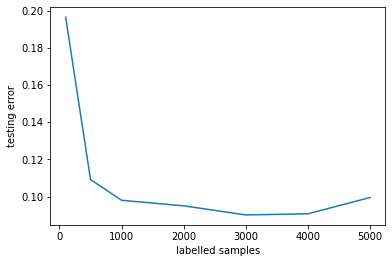

In [49]:
N_labels = [10, 50, 100, 200, 300, 400, 500]
N_labels_scaled = [i*10 for i in N_labels] # 10 for each class so total number of labelled samples should times 10
M1_err = [1-i for i in M1_accuracys]
plt.plot(N_labels_scaled, M1_err)
plt.xlabel("labelled samples")
plt.ylabel("testing error")

In [10]:
# run the same for M2
# Only use N labelled examples per class
# The rest of the data is unlabelled.
y_dim = 10
z_dim = 32
h_dim = [256, 128]

# # 28* 28 input images so the input is 784, 
# # in the decoder, in_feature = 32+10(y_dim) = 42
sampler = ImportanceWeightedSampler(mc=1, iw=1)
model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)

# number of labelled instances per class
N_labels = [10, 50, 100, 200, 300, 400, 500]
BATCH_SIZE = 32
M2_accuracys = []

for N in N_labels:
    model = DeepGenerativeModel([784, y_dim, z_dim, h_dim])   
    labelled, unlabelled, validation = get_mnist(location="./", batch_size=BATCH_SIZE, labels_per_class=N)
    alpha = 0.1 * len(unlabelled) / len(labelled)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
    print("Label per class = ", N)

    for epoch in range(5):
        # tell the model to train
        model.train()
        total_loss, accuracy = (0, 0)

        labelled_iter = iter(labelled)
      
       # making sure we've seen all labelled cases:
       # if no labelled case iter until we see one
        for (u, _) in unlabelled:
            labelled_elem = next(labelled_iter, None)
            if labelled_elem is None:
                labelled_iter = iter(labelled)
                labelled_elem = next(labelled_iter, None)
            (x, y) = labelled_elem

        # for (x, y), (u, _) in zip(iter(labelled), iter(unlabelled)):
            
        #     # maybe bounded by the shortest, need to maintain a separate iterator for the labelled data


        #     # forward + backward + optimize
        #     # Wrap in variables
            x, y, u = Variable(x), Variable(y), Variable(u)
            
            L = -elbo(x, y)
            U = -elbo(u) # using unlabelled data
            # Add auxiliary classification loss q(y|x)
            logits = model.classify(x)
            
            # Regular cross entropy
            classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L - alpha * classication_loss + U

            J_alpha.backward()
            # update params
            optimizer.step()

            # clear params 
            optimizer.zero_grad()

            total_loss += torch.Tensor.item(J_alpha.data)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
        
        # end of each epoch 
        if epoch % 1 == 0:
            # tell the model to test
            model.eval()
            m = len(unlabelled)
            print("training")
            print("Epoch: {}".format(epoch+1))
            print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

            total_loss, accuracy = (0, 0)

            for x, y in validation:
                x, y = Variable(x), Variable(y)
                L = -elbo(x, y)
                U = -elbo(x)

                logits = model.classify(x)
                classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()
                J_alpha = L + alpha * classication_loss + U
                total_loss += torch.Tensor.item(J_alpha.data)
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

            m = len(validation)
            print("validation")
            print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m ))
            M2_accuracys.append(accuracy / m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Label per class =  10


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


training
Epoch: 1
[Train]		 J_a: 1115.71, accuracy: 0.99
validation
[Validation]	 J_a: 1161.82, accuracy: 0.73
training
Epoch: 2
[Train]		 J_a: 1111.87, accuracy: 1.00
validation
[Validation]	 J_a: 1168.81, accuracy: 0.73
training
Epoch: 3
[Train]		 J_a: 1111.75, accuracy: 1.00
validation
[Validation]	 J_a: 1174.37, accuracy: 0.73
training
Epoch: 4
[Train]		 J_a: 1111.73, accuracy: 1.00
validation
[Validation]	 J_a: 1179.39, accuracy: 0.73
training
Epoch: 5
[Train]		 J_a: 1111.66, accuracy: 1.00
validation
[Validation]	 J_a: 1184.04, accuracy: 0.73
Label per class =  50
training
Epoch: 1
[Train]		 J_a: 1113.84, accuracy: 0.97
validation
[Validation]	 J_a: 1117.94, accuracy: 0.87
training
Epoch: 2
[Train]		 J_a: 1111.93, accuracy: 1.00
validation
[Validation]	 J_a: 1118.73, accuracy: 0.87
training
Epoch: 3
[Train]		 J_a: 1111.88, accuracy: 1.00
validation
[Validation]	 J_a: 1119.15, accuracy: 0.87
training
Epoch: 4
[Train]		 J_a: 1111.86, accuracy: 1.00
validation
[Validation]	 J_a: 112

In [37]:
M2_accuracys

[tensor(0.7340),
 tensor(0.7260),
 tensor(0.7315),
 tensor(0.7322),
 tensor(0.7327),
 tensor(0.8651),
 tensor(0.8669),
 tensor(0.8706),
 tensor(0.8459),
 tensor(0.8735),
 tensor(0.8876),
 tensor(0.8921),
 tensor(0.8989),
 tensor(0.8988),
 tensor(0.9028),
 tensor(0.9094),
 tensor(0.9177),
 tensor(0.9253),
 tensor(0.9288),
 tensor(0.9265),
 tensor(0.9156),
 tensor(0.9267),
 tensor(0.9296),
 tensor(0.9347),
 tensor(0.9333),
 tensor(0.9198),
 tensor(0.9329),
 tensor(0.9382),
 tensor(0.9386),
 tensor(0.9443),
 tensor(0.9229),
 tensor(0.9346),
 tensor(0.9403),
 tensor(0.9430),
 tensor(0.9463)]

In [0]:
M2_acc = np.array([float(i.numpy()) for i in M2_accuracys])
M2_acc = M2_acc[np.arange(4,len(M2_acc), 5)]

array([0.1967, 0.1092, 0.098 , 0.095 , 0.0901, 0.0907, 0.0995])

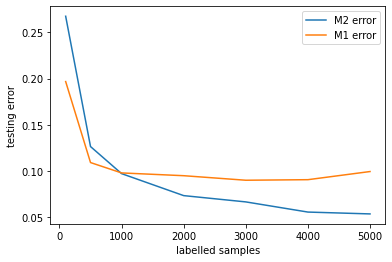

In [52]:
N_labels = [10, 50, 100, 200, 300, 400, 500]
N_labels_scaled = [i*10 for i in N_labels] # 10 for each class so total number of labelled samples should times 10
M2_err = 1-M2_acc
plt.plot(N_labels_scaled, M2_err, label='M2 error')
plt.plot(N_labels_scaled, M1_err, label='M1 error')
plt.xlabel("labelled samples")
plt.ylabel("testing error")
plt.legend()